# GCN: an introduction, in Keras

In this demo we implement a basic GCN layer, and then apply it to the popular Zachary's karate club problem.

In a karate club composed of 34 members a conflict arose between the administrator "John A" and instructor "Mr. Hi", which led to the split of the club into two different clubs. 

**Having knowledge of the relations between the members outside the club, the problem consists in guessing the correct repartition of the members among the two groups.**

In [ ]:
import tensorflow as ts
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

The problem is predefined in Python networkx library, and we can import data with a simple line.

In [ ]:
G = nx.karate_club_graph()

for v in G:
    print('%s %s' % (v, G.nodes[v]['club']))

0 Mr. Hi
1 Mr. Hi
2 Mr. Hi
3 Mr. Hi
4 Mr. Hi
5 Mr. Hi
6 Mr. Hi
7 Mr. Hi
8 Mr. Hi
9 Officer
10 Mr. Hi
11 Mr. Hi
12 Mr. Hi
13 Mr. Hi
14 Officer
15 Officer
16 Mr. Hi
17 Mr. Hi
18 Officer
19 Mr. Hi
20 Officer
21 Mr. Hi
22 Officer
23 Officer
24 Officer
25 Officer
26 Officer
27 Officer
28 Officer
29 Officer
30 Officer
31 Officer
32 Officer
33 Officer


Let us define the ground truth.

In [ ]:
n = len(G)

Labels = np.zeros(n)
for v in G:
   Labels[v] = G.nodes[v]['club'] == 'Officer'
print(Labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Let us inspect the graph structure.

Here we show the first egienvectors of the graph laplacian.

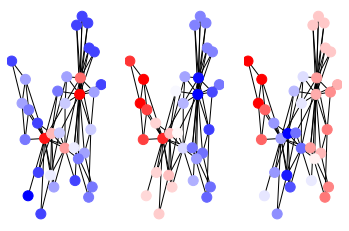

In [ ]:
NL = nx.normalized_laplacian_matrix(G).toarray()
lam,ev = np.linalg.eig(NL)

#print(np.dot(NL,ev[:,20]))
#print(lam[20]*ev[:,20])

import matplotlib.pyplot as plt
pos=nx.spring_layout(G) # positions for all nodes
plt.subplot(131)
nx.draw(G,pos,node_size=100, node_color=ev[:,0], cmap='bwr')
plt.subplot(132)
nx.draw(G,pos,node_size=100, node_color=ev[:,1], cmap='bwr')
plt.subplot(133)
nx.draw(G,pos,node_size=100, node_color=ev[:,2], cmap='bwr')



## GCN

Let us come to the code for computing the GCN layer.

We try to give a pretty intutive introduction to the topic. 

Suppose we have, for each node n, a vector of features X. We are interested to use these fetures to compute new features, 
e.g. by multiplying them with some learned parameters $\Theta$. 

The idea is that, in addition to the features of the node n, we would also take into account the structure of the graph, combining X with the features of its neigbours.

For instance, if we multiply X by (I + A) we sum together the features of each node and those of its adjacent nodes. Let us call $\hat{A} = I +A$.

A problem with $\hat{A}$, is that it is not normalized and therefore the multiplication with it may completely change the scale of the feature vectors. To address this issue, we can multiply $\hat{A}$ by $D^{-1}$, 
where $D$ is the diagonal node degree matrix:
in the resulting matrix, all rows will sum up to 1.

In practice, dynamics gets more interesting if you use a symmetric normalization, i.e. $D^{-\frac{1}{2}}AD^{−\frac{1}{2}}$ (that no longer amounts to mere averaging of neighboring nodes). 

With the combination of the previous two tricks, we arrive at the GCN rule introduced in Kipf & Welling (ICLR 2017):

<center>$f(A,X)=\sigma(D^{-\frac{1}{2}}\hat{A}D^{−\frac{1}{2}}X\Theta)$</center>

* $\hat{A}$ has dimension $n\times n$ (likewise D)
* X has dimension $n \times p$
* $\Theta$ has dimension $p \times q$
* the output has dimension $n \times q$


In [ ]:
A = nx.adjacency_matrix(G)
Id = np.ones(n)
Id = np.diag(Id)
Ahat = A + Id
rowsum = np.array(Ahat.sum(1))
r_inv = np.power(rowsum, -.5).flatten()
r_inv[np.isinf(r_inv)] = 0.
r_mat_inv = np.diag(r_inv)
Anorm = np.dot(r_mat_inv,np.dot(Ahat,r_mat_inv))

We now define our costum GCN layer. We use the utility function add_weight in order to introduce the matrix $\Theta$ of learnable parameters. 

The layer expects to receive as input an already normalized matrix $A$ (in addition to $X$), so we merely compute the dot product $AX\Theta$.

In [ ]:
class GCNlayer(layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GCNlayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        #print(input_shape)
        self._Theta = self.add_weight(name='Theta', 
                                    shape=(input_shape[1][2], self.output_dim),
                                    initializer='glorot_uniform',
                                    trainable=True)
        super(GCNlayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self,x):
        A, X = x
        return K.batch_dot(A, K.dot(X, self._Theta),axes=[2,1])

    def compute_output_shape(self, input_shape):
        return (None,input_shape[0][1], self.output_dim)

We define a simple model composed of three GCN layers. The final layer has output dimension 1, and we pass it to the logistic function to produce the output probability to belong to a given club.

In [ ]:
noFeat = 5

Adj = layers.Input(shape=Anorm.shape)
Feat = layers.Input(shape=(n,noFeat,))
Z = GCNlayer(10)([Adj,Feat])
#Z = Activation('relu')(Z)
Z = GCNlayer(10)([Adj,Z])
#Z = Activation('relu')(Z)
Z = GCNlayer(1)([Adj,Z])
Zres = layers.Activation('sigmoid')(Z)

gcnmodel = Model(inputs=[Adj,Feat],outputs=[Zres])

In [ ]:
gcnmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34, 34)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 34, 5)]      0                                            
__________________________________________________________________________________________________
gc_nlayer_3 (GCNlayer)          (None, 34, 10)       50          input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
gc_nlayer_4 (GCNlayer)          (None, 34, 10)       100         input_3[0][0]                

We shall train the model starting with random features, in a **semi-supervised** setting, where we only know the final label for the Mr.Hi (number 0, label 0) and the Officer (number 33, label 1).

The loss is just measured on these two nodes, for which we know the True labels. The connectivity of the networks allows to propagate labels to adjacent nodes.

In [ ]:
loss = - K.log(1-Zres[:,0]) - K.log(Zres[:,33])
#loss = K.square(Zres[:,0]) + K.square(1-Zres[:,33])

gcnmodel.add_loss(loss)
gcnmodel.compile(optimizer='nadam')

In [ ]:
X = np.random.normal(size = (n,noFeat))

In [ ]:
gcnmodel.fit([Anorm[np.newaxis,:],X[np.newaxis,:]],epochs=300)

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 1.4707
Epoch 2/300
1/1 [==============================] - 0s 7ms/step - loss: 1.4618
Epoch 3/300
1/1 [==============================] - 0s 4ms/step - loss: 1.4554
Epoch 4/300
1/1 [==============================] - 0s 4ms/step - loss: 1.4495
Epoch 5/300
1/1 [==============================] - 0s 4ms/step - loss: 1.4437
Epoch 6/300
1/1 [==============================] - 0s 4ms/step - loss: 1.4379
Epoch 7/300
1/1 [==============================] - 0s 4ms/step - loss: 1.4320
Epoch 8/300
1/1 [==============================] - 0s 4ms/step - loss: 1.4260
Epoch 9/300
1/1 [==============================] - 0s 3ms/step - loss: 1.4200
Epoch 10/300
1/1 [==============================] - 0s 4ms/step - loss: 1.4139
Epoch 11/300
1/1 [==============================] - 0s 5ms/step - loss: 1.4078
Epoch 12/300
1/1 [==============================] - 0s 4ms/step - loss: 1.4018
Epoch 13/300
1/1 [==============================] - 0s 4ms/ste

In [ ]:
predictions = gcnmodel.predict([Anorm[np.newaxis,:],X[np.newaxis,:]])[0,:,0]
#print(predictions)
predlabels = predictions > .5
#print(predlabels)
accuracy = np.sum(predlabels==Labels)/n
print(accuracy)

0.8529411764705882


Considering that the model received random feature description of the nodes, this is a remarkable result. The accuracy can be further improved by providing initial node features as e.g. derived by some node embedding, as in the experiment described in Kipf & Welling article.